# Chapter 4: Simulation

## 4.1  Software Design Principles

### 4.1.1 Object-Oriented Programming (OOP)

In [1]:
# The "Position" class holds information relevant to a single trade troughout its life.
# it can report information relevant to single trades, and check that trading activity is no erroneously recorded.

In [2]:
# The "PortfolioHistory" class holds a list of "Position" objects, records historical balances of cash,
# and reports on performance and behavior of the portfolio overall.
# it is also responsible for computing the equity curve, return series, and any performance metrics.

In [3]:
# The "SimpleSimulator" class holds data about the prices, signals, and preferences of different stocks.
# It is primarily responsible for stepping through time, while managing "Position" objects and recording
# events in the "PortfolioHistory" object.

In [4]:
# in order to write efficient code,liberal use of advanced Python programming features including...
# decorators
# static methods
# pseudo-private attributes
# pass-by-reference
# magic methods
# lambda functions

### 4.1.2  Defensive Programming

In [5]:
'''
The SimpleSimulator is responsible for managing multiple instances of the other 2 classes.
as such, it is possible and quite likely it will perform some undefined behavior at some point, such as:
- Opening and closing a position at the same instant
- Recording the same position multiple times in the portfolio history
- Recording an unclosed position
- Recording cash and portfolio histories along different sets of dates
- Having a negative cash balance
- Having multiple positions open in the same asset at the same time
'''

'\nThe SimpleSimulator is responsible for managing multiple instances of the other 2 classes.\nas such, it is possible and quite likely it will perform some undefined behavior at some point, such as:\n- Opening and closing a position at the same instant\n- Recording the same position multiple times in the portfolio history\n- Recording an unclosed position\n- Recording cash and portfolio histories along different sets of dates\n- Having a negative cash balance\n- Having multiple positions open in the same asset at the same time\n'

In [6]:
# 4.1: assert method examples

assert 2 + 2 == 4, 'The laws of mathematics are crumbling.'
assert 2 + 2 == 5, 'You will see this message in an AssertionError'

AssertionError: You will see this message in an AssertionError

## 4.2  Building a Simulator

### 4.2.1  Defining Supported Behanvior and Constraints

In [7]:
#  The strategy will open and close long positions on a fixed maximum number of distinct assets simultaneously.
#   - Entry and exit dates can be asynchronous
#   - The number of shares held of each asset will be fixed over the length of the trade
#   - Cash will be divided equally among available opportunies at time of purchase
#   - Purchase of fractional shares is allowed for mathematical simplicity

In [8]:
#  The simulator will support fees and slippage.
#   - A fixed trade fee is supported. It will be charged once to the cash balance upon purchase, but not sale, of an asset
#   - A percentage slippage amount is supported, of which will be applied adversely to the portfolio on both purchase and sale of an asset.

In [9]:
#  The input data will consist of three date-indexed data frames with column names representing the assets under consideration.
#   - Price will be a data frame of closing prices
#   - Signal will be a data frame with integers in the set, {-1,0,1}, where -1 represents sell, 0 represents no signal, and 1 represents buy
#   - Preference will be a data frame of floats representing relative preference for each symbol at any point in time.
#     which may be entirely independent of the signal.
#     The preferences will be use to determine which assets are bought or swapped out in the case of many concurrent buy signals.
#   - The input data is assumed to have null values at the beginning of a series, but a non-null series cannot become null once it is in play,
#     as the simulator moves forward in time. (i.g. stocks can be listed, but no delisted, during the simulation time frame)

### 4.2.2  Defining a Position Object

In [24]:
# The 'Position' class and a 'position' object are defined as follows:

import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from typing import Tuple, List, Dict, Callable, NewType, Any
from collections import OrderedDict, defaultdict

from pypm import metrics, signals, data_io

In [11]:
# 4.2  Position and class definition

Symbol = NewType('Symbol', str)
Dollars = NewType('Dollars', float)

DATE_FORMAT_STR = '%a %b %d, %Y'

def _pdate(date: pd.Timestamp):
    '''
    Pretty-print a datetime with just the date
    '''
    return date.strftime(DATE_FORMAT_STR)

class Position(object):
    '''
    A simple object to hold and manipulate data related to long stock trades.
    
    Allows a single buy and sell operation on an asset for a constant number of shares.
    
    The __init__ method is equivelant to a buy operation. The exit method is a sell operation.
    '''
    def __init__(self, symbol: Symbol, entry_date: pd.Timestamp, entry_price: Dollars, shares: int):
        '''
        Equivelent to buying a certian number of shares of the asset
        '''
        
        # Recorded on initializatoin
        self.entry_date = entry_date
        self.entry_price = entry_price
        self.shares = shares
        self.symbol = symbol
        
        # Recorded on position exit
        self.exit_date: pd.Timestamp = None
        self.exit_price: Dollars = None
        
        # For easily getting current portfolio value
        self.last_date: pd.Timestamp = None
        self.last_price: Dollars = None
            
        # Updated intermediately
        self._dict_series: Dict[pd.Timestamp, Dollars] = OrderedDict()
        self.record_price_update(entry_date, entry_price)
        
        # Cache control for pd.Series representation
        self._price_series: pd.Series = None
        self._needs_update_pd_series: bool = True
    
    def exit(self, exit_date, exit_price):
        '''
        Equivelent to selling a stock holding
        '''
        assert self.entry_date != exit_date, 'Churned a position same-day.'
        assert not self.exit_date, 'Position already closed.'
        self.record_price_update(exit_date, exit_price)
        self.exit_date = exit_date
        self.exit_price = exit_price
        
    def record_price_update(self, date, price):
        '''
        Stateless function to record intermediate prices of existing positions
        '''
        self.last_date = date
        self.last_price = price
        self._dict_series[date] = price
        
        # Invalidate cache on self.price_series
        self._needs_update_pd_series = True
        
    @property
    def price_series(self) -> pd.Series:
        '''
        Returns cached read-only pd.Series
        '''
        if self._needs_update_pd_series or self._price_series is None:
            self._price_series = pd.Series(self._dict_series)
            self._needs_update_pd_series = False
        return self._price_series
    
    @property
    def last_value(self) -> Dollars:
        return self.last_price * self.shares
    
    @property
    def is_active(self) -> bool:
        return self.exit_date is None
    
    @property
    def is_closed(self) -> bool:
        return not self.is_active
    
    @property
    def value_series(self) -> pd.Series:
        '''
        Returns the value of the position over time. Ignores self.exit_date.
        Used in calculating the equity curve
        '''
        assert self.is_closed, 'Position must be closed to access this property'
        return self.shares * self.price_series[:-1]
    
    @property
    def percent_return(self) -> float:
        return (self.exit_price / self.entry_price) - 1
    
    @property
    def entry_value(self) -> Dollars:
        return self.shares * self.entry_price
    
    @property
    def exit_value(self) -> Dollars:
        return self.shares * self.exit_price
    
    @property
    def change_in_value(self) -> Dollars:
        return self.exit_value - self.entry_value
    
    @property
    def trade_length(self):
        return len(self._dict_series) - 1
    
    
    def print_position_summary(self):
        _entry_date = _pdate(self.entry_date)
        _exit_date = _pdate(self.exit_date)
        _days = self.trade_length
        
        _entry_price = round(self.entry_price, 2)
        _exit_price = round(self.exit_price, 2)
        
        _entry_value = round(self.entry_value, 2)
        _exit_value = round(self.exit_value, 2)
        
        _return = round(100 * self.percent_return, 1)
        _diff = round(self.change_in_value, 2)
        
        print(f'{self.symbol:<5}     Trade Summary')
        print(f'Date:    {_entry_date} -> {_exit_date} [{_days} days]')
        print(f'Price:   ${_entry_price} -> ${_exit_price} [{_return}%]')
        print(f'Value:   ${_entry_value} -> ${_exit_value} [${_diff}]')
        print()
        
    def __hash__(self):
        '''
        A unique position will be defined by a unique combination of an 
        entry_date and symbol, in accordance with our constraints regarding
        duplicate, variable, and compound positions
        '''
        return hash((self.entry_date, self.symbol))

In [ ]:
df = pd.read_csv('data/eod/AWU.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index(df['date'], inplace=True)
df.drop(columns=['date'], inplace=True)
df.info()

In [ ]:
plt.plot(Position.price_series, df['close'])

In [13]:
# 4.3 Position object usage

from pypm import data_io, portfolio

symbol = 'AWU'
df = data_io.load_eod_data(symbol)
shares_to_buy = 50

for i, row in enumerate(df.itertuples()):
    date = row.Index
    price = row.close
    
    if i == 123:
        position = portfolio.Position(symbol, date, price, shares_to_buy)
    elif 123 < i < 234:
        position.record_price_update(date, price)
    elif i == 234:
        position.exit(date, price)
        
position.print_position_summary()

AWU       Trade summary
Date:     Wed Jun 30, 2010 -> Tue Dec 07, 2010 [111 days]
Price:    $220.34 -> $305.98 [38.9%]
Value:    $11017.0 -> $15299.0 [$4282.0]



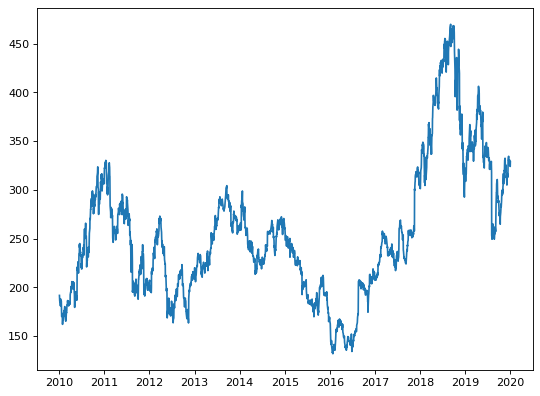

In [25]:
figure(figsize=(8, 6), dpi=80)

plt.plot(df.index, df['close'])

<Figure size 640x480 with 0 Axes>

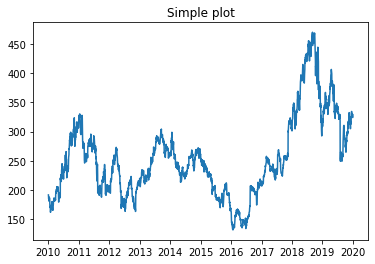

<Figure size 640x480 with 0 Axes>

In [29]:
# First create some toy data:
x = df.index
y = df['close']

# Create just a figure and only one subplot
fig, ax = plt.subplots()
ax.plot(x, y)
ax.set_title('Simple plot')

figure(figsize=(8, 6), dpi=80)

<Figure size 640x480 with 0 Axes>

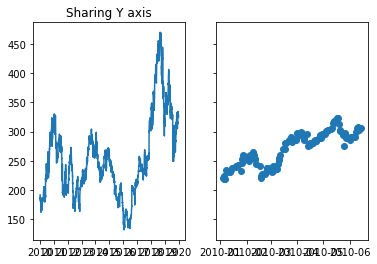

In [28]:
# Create two subplots and unpack the output array immediately
figure(figsize=(8, 6), dpi=80)

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.plot(x, y)
ax1.set_title('Sharing Y axis')
ax2.scatter(x[:112], position.price_series)